In [1]:
# Preprocessing
import pandas as pd
import tables
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
sys.path.append('/home/iprovilkov/data/JUNO/notebooks/')

In [2]:
from data_utils.data_processing import get_data_2dprojection
from data_utils.data_generator import DataGenerator

Using TensorFlow backend.


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [4]:
LTRAIN = '/mnt/iprovilkov/data_dir/npdata/'
rg = np.arange(0,100000,20000)
MAXR = 17200

In [5]:
from tensorflow.python.client import device_lib
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
import keras
import keras.layers as L
from keras.models import Sequential
from keras import backend as K
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
import keras.layers as L
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.engine.input_layer import Input
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
NAME = 'ResNet_xyz'
train_columns = ['x', 'y', 'z']

In [7]:
edge_size0 = 226
edge_size1 = 112
inputs = Input(shape=(edge_size0,edge_size1,2))

In [8]:
from keras import layers
from keras import models


#
# image dimensions
#

img_height = edge_size0
img_width = edge_size1
img_channels = 2

#
# network params
#

cardinality = 1


def residual_network_tail(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)
        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:
        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.LeakyReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(64, kernel_size=(7, 7), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 128, 256, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 512, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 512, 1024, _strides=strides)

    # conv5
    #for i in range(3):
    #    strides = (2, 2) if i == 0 else (1, 1)
    #    x = residual_block(x, 1024, 2048, _strides=strides)
    print(x.shape)
    return x

In [9]:
base_model = residual_network_tail(inputs)

(?, 15, 7, 1024)


In [11]:
x = L.MaxPool2D()(base_model)
x = L.Flatten()(x)
# let's add a fully-connected layer
#x = L.Dropout(0.)(x)
x = Dense(512, activation=layers.LeakyReLU())(x)
#x = L.Dropout(0.5)(x)
x = Dense(512, activation=layers.LeakyReLU())(x)
x = Dense(512, activation=layers.LeakyReLU())(x)
predictions = Dense(len(train_columns))(x)

/home/iprovilkov/data/p3.5/lib/python3.5/site-packages/keras/activations.py:197: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [12]:
model = Model(inputs=inputs, outputs=predictions)

In [13]:
model.compile(optimizer=Adam(), loss='mean_squared_error')

In [14]:
model.build(input_shape=(None, edge_size0,edge_size1,2))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 226, 112, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 113, 56, 64)  6336        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 113, 56, 64)  256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 113, 56, 64)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [15]:
logdir = NAME + '.csv'

In [16]:
from keras.callbacks import CSVLogger, ReduceLROnPlateau
csv_logger = CSVLogger(logdir, append=True, separator=';')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.000001)

In [17]:
TRAIN_DIR = '~/data/data_dir/'
#tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [37]:
big_file_names = []
rg = np.arange(0,100001,20000)
#mask_names = []
y_true_names = []
for id1 in range(9):
    for start in rg[:-1]:
        big_file_names.append(LTRAIN + '_' + str(id1) + '_' + str(start) + 'noise_sin.npy')
    #mask_names.append(LTRAIN +'_'+str(id1)+'_mask.npy')
    y_true_names.append(LTRAIN +'_'+str(id1)+'_true_info.csv')

In [38]:
TRAIN_DIR = '~/data/data_dir/'
#tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')
tr_true_info = pd.read_csv(y_true_names[-1])

In [39]:
X_test = np.load(big_file_names[-1])

In [40]:
y_test = tr_true_info[(tr_true_info['evtID'] >= 80000) 
                     & (tr_true_info['evtID'] < 100000)]
mask = (y_test.R <= MAXR)
X_test = X_test[mask]
y_test = y_test[mask][train_columns].values

In [41]:
def scaler(X,y):
    X[X<0]=0
    X[:,:,:,1] /= 20 
    y /= 100

In [42]:
scaler(X_test, y_test)

In [43]:
rg = np.arange(0,100001,20000)

In [44]:
from data_utils.data_generator import DataGeneratorBig

In [49]:
training_generator = DataGeneratorBig(24,
                                    rg=rg,
                                    file_names=big_file_names,
                                    y_true_names= y_true_names,
                                    target_names=train_columns,
                                    scaler=scaler)

Big pieces 9
Small pieces 5

 Big id  0 small id 0

 Load files /mnt/iprovilkov/data_dir/npdata/_0_0noise_sin.npy   /mnt/iprovilkov/data_dir/npdata/_0_true_info.csv
Ids from:  0  to  20000


In [50]:
#X_test = np.load(LTRAIN + '_' + str(rg[-2]) +'without_noise_sin.npy')

In [51]:
#training_generator = DataGenerator(24,rg=rg,
#                                file_names=[LTRAIN + '_' + str(start) +'without_noise_sin.npy' for start in rg[:-2]],
#                                  y_true=tr_true_info,
#                                  target_names=train_columns,
#                                  scaler=scaler)

In [52]:
model.fit_generator(generator=training_generator,
                    validation_data=(X_test, y_test),
                    use_multiprocessing=True,
                    workers=6,
                    callbacks=[csv_logger, reduce_lr],
                   epochs=4*20)

Epoch 1/80
765/766 [============================>.] - ETA: 0s - loss: 1.5783Epoch 1/80

 Big id  0 small id 1

 Load files /mnt/iprovilkov/data_dir/npdata/_0_20000noise_sin.npy   /mnt/iprovilkov/data_dir/npdata/_0_true_info.csv
Ids from:  20000  to  40000
766/766 [==============================] - 751s 980ms/step - loss: 1.5795 - val_loss: nan
Epoch 2/80
765/766 [============================>.] - ETA: 0s - loss: 1.6500
 Big id  0 small id 2

 Load files /mnt/iprovilkov/data_dir/npdata/_0_40000noise_sin.npy   /mnt/iprovilkov/data_dir/npdata/_0_true_info.csv
Ids from:  40000  to  60000
766/766 [==============================] - 750s 979ms/step - loss: 1.6496 - val_loss: nan
Epoch 3/80
370/766 [=============>................] - ETA: 5:04 - loss: nan

Process ForkPoolWorker-542:
Process ForkPoolWorker-546:
Process ForkPoolWorker-544:
Process ForkPoolWorker-541:
Process ForkPoolWorker-543:
Process ForkPoolWorker-545:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/iprovilkov/data/p3.5/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/

KeyboardInterrupt: 

In [36]:
model.save_weights(NAME + '.h5')
with open(NAME + ".json", "w") as json_file:
    json_file.write(model.to_json())

(0, 3)

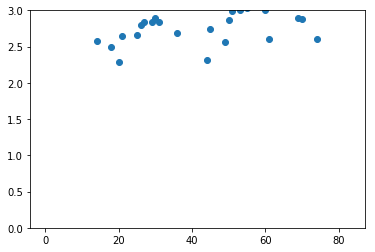

In [35]:
cs = pd.read_csv(logdir, sep=';')
cs = cs
plt.scatter(np.arange(0, cs.shape[0]), cs['val_loss'].values)
plt.ylim(0,3)

(0, 3)

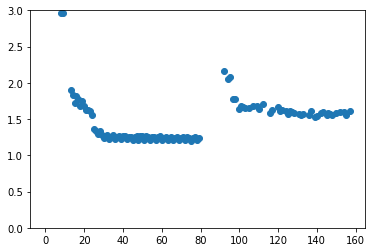

In [31]:
plt.scatter(np.arange(0, cs.shape[0]), cs['loss'].values)
plt.ylim(0,3)

In [32]:
from sklearn.metrics.pairwise import paired_euclidean_distances
from sklearn.metrics import mean_squared_error

In [33]:
preds = model.predict(X_test)
test_resultsE = mean_squared_error(preds[:,0], y_test[:,0])

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
preds[:3]

In [ ]:
y_test[:3]

In [ ]:
test_resultsE.mean() * 10

In [ ]:
r_res = tr_true_info[(tr_true_info['evtID'] >= rg[-2]) 
             & (tr_true_info['evtID'] < rg[-1])]['R'][mask].values

In [ ]:
r_pred = np.sqrt(preds[:,0] ** 2 + preds[:,1] ** 2 + preds[:,2] ** 2) * 100

In [ ]:
r_pred

In [ ]:
np.std(r_pred-r_res)/10

In [74]:
preds[:,0]

array([130.07462  ,  -4.4070907,  -1.303009 , ..., -41.64325  ,
       -70.071526 , -59.13257  ], dtype=float32)

In [75]:
from tqdm import tqdm

In [76]:
root_data_path = '/mnt/iprovilkov/data_dir/0MeV_lpmt_hits.h5'

In [77]:
def test_sigmas(model, test_dir='/mnt/iprovilkov/data_dir/', test_column='E', MAXR=MAXR, 
                time=False, recompute=False):
    sigmas = {}
    MSEs = {}
    predictions = {}
    CONST = 1.022
    for energy in tqdm(range(10)):
        try:
            if recompute:
                raise Exception("Recompute")
            if time:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_without_noise_sin.npy')
            else:
                data_lpmt = np.load(test_dir + str(energy) + 'data_lpmt_without_noise_sin.npy')
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
        except: 
            lpmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+ 'lpmt_hits.h5', mode='r') 
            spmt_hits = pd.read_hdf(test_dir + str(energy)+'MeV_'+'spmt_hits.h5', mode='r')
            lpmt_hits = lpmt_hits[lpmt_hits.isDN==False]
            spmt_hits = spmt_hits[spmt_hits.isDN==False]
            pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'lpmt_pos.csv') 
            spmt_pos = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'spmt_pos.csv') 
            true_info = pd.read_csv(TRAIN_DIR + str(energy)+'MeV_'+'true_info.csv')
            if time:
                print("Compute...")
                data_lpmt, event_to_id = get_data_2dprojection(lpmt_hits,
                                                None,
                                                pos,
                                                true_info,
                                                edge_size0=226,
                                                edge_size1=112,
                                                use_spmt=False,
                                                time='min',
                                                )
                np.save(test_dir+str(energy)+'data_lpmt_without_noise_sin', data_lpmt)
            else:
                pass
            
        mask = (true_info.R<=MAXR)
        data_lpmt = data_lpmt[mask]
        true_info = true_info[mask]
        y_test = true_info[test_column].values
        scaler(data_lpmt, 0)
        
        preds = model.predict(data_lpmt)
        r_pred = np.sqrt(preds[:,0] ** 2 + preds[:,1] ** 2 + preds[:,2] ** 2) * 100
        
        
        predictions[energy] = preds
        MSEs[energy] = mean_squared_error(r_pred, y_test)
        # in percents
        if test_column == 'E':
            sigmas[energy] = np.std(preds - y_test) / (energy + CONST)
        if test_column == 'R':
            print(preds[:10])
            print(y_test[:10])
            sigmas[energy] = np.std(r_pred - y_test)
    print("+")
    return sigmas, MSEs, predictions

In [78]:
sigmas, MSEs, predictions = test_sigmas(model, test_column='R', time=True, recompute=False)

 10%|█         | 1/10 [00:15<02:18, 15.35s/it]

[[  50.308064   -52.37213     97.21417  ]
 [-107.1563     -60.952007   -19.21875  ]
 [  12.475608  -124.44054    -53.980873 ]
 [  47.089504    12.5415125 -145.54439  ]
 [ -46.747337    43.402447  -144.9967   ]
 [ -75.2759      14.447427   125.774025 ]
 [ -27.374847    42.29899    106.41108  ]
 [  29.637733    31.363514   128.74617  ]
 [ -23.103745  -103.58135     43.552284 ]
 [  -7.392915  -106.10224    -21.489017 ]]
[13685.387 13767.972 14483.374 16385.209 16535.102 16292.973 13321.352
 14847.134 12601.948 12191.814]


 20%|██        | 2/10 [00:31<02:04, 15.53s/it]

[[  54.226974   -61.13883    102.943985 ]
 [  34.991856    20.779852   122.09949  ]
 [ -78.08004     -7.620925   -41.353718 ]
 [-102.27101     -9.294452   -87.64408  ]
 [  32.157024   -23.329393    83.95305  ]
 [ -61.62151     35.752712    37.067474 ]
 [ -16.928286    97.68358    117.18938  ]
 [  17.92713     62.033184    46.404133 ]
 [   2.8727803   45.14209    -42.474594 ]
 [ -44.901207    72.56152    101.20459  ]]
[13685.387  13410.883   9433.555  13953.234   9949.386   8924.891
 15597.524   8686.9375  6877.779  13697.783 ]


 30%|███       | 3/10 [00:47<01:49, 15.61s/it]

[[  54.294422   -59.8356     104.59942  ]
 [  15.97833    -46.24078     76.75696  ]
 [  75.44591   -122.64689     16.66754  ]
 [-100.44763    -30.514822    24.777723 ]
 [  -7.219162   143.53148    -38.836895 ]
 [  68.507744     2.8670971   67.02036  ]
 [ -93.38353     26.538488    79.23382  ]
 [ -32.451347    42.95527     14.359312 ]
 [ -19.81224     42.886818   162.62827  ]
 [   6.2675843  -31.657421   -17.992088 ]]
[13685.387   9459.184  14780.856  11244.336  15168.536   9857.545
 13065.209   5716.9985 17010.791   3766.2598]


 40%|████      | 4/10 [01:02<01:33, 15.56s/it]

[[  54.97248   -60.13053   106.4262  ]
 [  37.634354  -79.77739   123.592026]
 [  45.98878  -139.38303    22.457384]
 [ -17.689392  109.66811   -42.907497]
 [  32.554543  121.70613    87.821625]
 [ -52.727245  108.71663   -93.40964 ]
 [  -9.450058 -120.44161    44.622993]
 [  37.138218   80.42331   -96.6786  ]
 [  69.757385   88.48028   -40.242943]
 [ 100.925606  120.86539   -21.814766]]
[13685.387 15327.389 14982.    12146.219 15341.161 15562.079 13139.039
 13423.874 12005.3   15854.112]


 50%|█████     | 5/10 [01:18<01:18, 15.75s/it]

[[  56.444057   -60.93007    107.31163  ]
 [ -73.454956  -110.83328    -45.974457 ]
 [ 110.82125    -15.71816     -1.8822999]
 [ 118.31239    -45.318905   -60.220516 ]
 [  -0.6144208  -88.881714   -53.16191  ]
 [  90.92868      1.891503   -49.98538  ]
 [  -9.497971  -117.40253     59.894726 ]
 [ -29.011488    10.203716   -75.2547   ]
 [  63.37292    -28.105413    87.29545  ]
 [  44.7682    -150.3084      23.701681 ]]
[13685.387  14200.797  11200.73   14083.442  10510.377  10500.41
 13247.246   8158.7183 11431.432  15828.905 ]


 60%|██████    | 6/10 [01:35<01:03, 15.92s/it]

[[  55.734055  -60.023773  108.280815]
 [  32.664497  -74.12623   -20.82298 ]
 [  46.802956  102.331795   44.066956]
 [ -67.410995   73.553345 -130.02144 ]
 [  32.760033  -90.128075   63.225525]
 [-102.333046  -96.80134    66.37391 ]
 [ 115.418465  110.132805   18.666903]
 [ 114.21833   -79.73019   -77.75164 ]
 [-150.69154    36.02957    60.28692 ]
 [   9.094999  -54.7956   -105.160706]]
[13685.387  8422.246 12181.572 16394.582 11673.857 15601.306 16126.187
 16045.935 16654.432 12175.233]


 70%|███████   | 7/10 [01:50<00:47, 15.79s/it]

[[  57.06489    -61.115475   107.16238  ]
 [ -18.123995   -55.01874    102.393875 ]
 [-104.52033    -47.67433    -33.287277 ]
 [ -97.37369     59.985554    -3.6880367]
 [  71.06073   -114.99007     18.787462 ]
 [ -24.610332   120.60732    -64.97138  ]
 [  51.11451   -127.34094    101.02286  ]
 [  29.646303    64.31788    -70.33352  ]
 [ -46.541943   105.39632    -26.549225 ]
 [ -34.663464  -107.36482    -56.817673 ]]
[13685.387 11922.321 12114.285 11516.515 13680.285 13979.825 17108.254
 10130.919 11991.952 12682.488]


 80%|████████  | 8/10 [02:06<00:31, 15.94s/it]

[[ 5.65655365e+01 -6.02552299e+01  1.08129135e+02]
 [ 2.79574528e+01  4.76340752e+01 -1.15504097e+02]
 [ 9.52251358e+01  1.04946472e+02  3.44257698e+01]
 [ 7.66017294e+00  7.97987061e+01  1.07802986e+02]
 [-3.99337959e+01 -1.53841522e+02 -5.90360069e+01]
 [-9.19292374e+01 -1.00068115e+02 -4.43079185e+01]
 [ 4.38593330e+01 -7.74168701e+01 -7.74235611e+01]
 [ 7.54643555e+01 -6.72974625e+01  9.09858475e+01]
 [ 4.64267063e+00 -4.67655137e-02 -9.04807892e+01]
 [-2.65010490e+01  2.95399189e+01 -1.10102707e+02]]
[13685.387 12958.754 14612.41  13395.118 17146.44  14422.13  11942.524
 13709.816  9141.089 11901.334]


 90%|█████████ | 9/10 [02:22<00:15, 15.81s/it]

[[  59.007614   -59.764248   107.41791  ]
 [-137.21072    -36.459427    -8.338824 ]
 [-143.21268     15.370227    60.620556 ]
 [ 127.592674    30.338604   -20.518457 ]
 [ -85.83177     40.246437     6.1958814]
 [ -75.3584     -98.68637     45.69767  ]
 [  12.616635    25.228838   -36.815994 ]
 [  18.692513    49.22274    -74.05139  ]
 [ -44.844173    28.143152    90.75285  ]
 [ -29.607029    55.196186   -64.31718  ]]
[13685.387  14392.851  15712.894  13303.8545  9530.68   13284.986
  4756.147   9080.496  10546.205   9097.196 ]


100%|██████████| 10/10 [02:38<00:00, 15.78s/it]

[[  57.02605   -60.923946  108.708275]
 [ -67.453026   44.60745    74.95427 ]
 [ 132.87634    30.673576  -81.01619 ]
 [ -10.577841   -5.945405  -25.77473 ]
 [ -19.55162    39.782154  107.9342  ]
 [-112.26027    40.476994  119.54604 ]
 [  37.3418    152.31697    55.578278]
 [ -44.99054  -114.767815  -41.97224 ]
 [  63.879753  114.72657   -75.87053 ]
 [  93.06755    13.838189  -12.252793]]
[13685.387 11129.92  15775.158  2958.306 11732.66  16947.965 16712.424
 13047.53  15077.495  9472.099]
+


In [79]:
sigmas, MSEs

({0: 358.01071246442365,
  1: 197.95548359959056,
  2: 141.57965121597655,
  3: 117.87557339313085,
  4: 113.87165654154627,
  5: 104.20756018419357,
  6: 108.66369212627092,
  7: 108.51772068327003,
  8: 111.31512345497208,
  9: 115.58183148606362},
 {0: 1020728.7823887428,
  1: 228395.91834603186,
  2: 88989.77527152991,
  3: 45954.38744295541,
  4: 30154.4833100767,
  5: 21387.735198815855,
  6: 18327.609246622298,
  7: 16314.960785131194,
  8: 15366.48561517791,
  9: 15860.693744973945})

In [78]:
a = 2.8
b=0.59
c=0

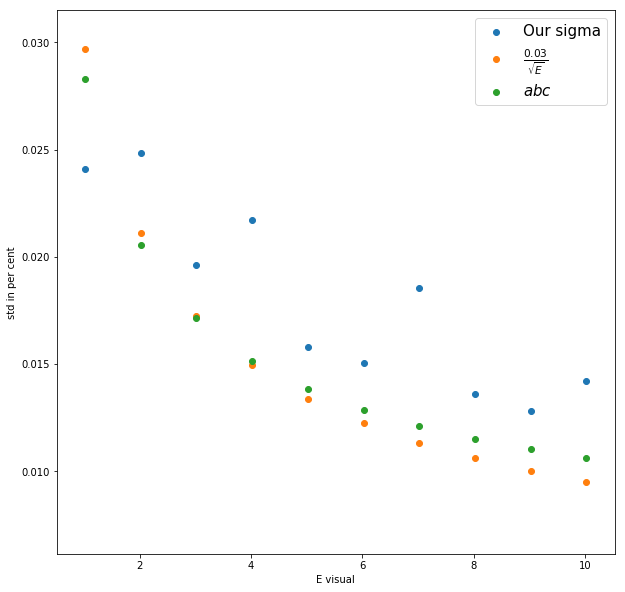

In [79]:
# Plot sigmas
Evis = np.array([en + 1.022  for en in range(10)])
Perc_sigmas = [sigmas[en] for en in range(10)]
perc_3_sqrt_E = [0.03 / np.sqrt(en) for en in Evis]
fig = plt.figure(figsize=(10,10))
plt.scatter(Evis, Perc_sigmas, label='Our sigma')
plt.scatter(Evis, perc_3_sqrt_E, label=r'$\frac{0.03}{\sqrt{E}}$')
plt.scatter(Evis, 0.01*np.sqrt((a/np.sqrt(Evis))**2 + b**2 + (c/Evis)**2), label=r'$abc$')
plt.ylabel("std in per cent")
plt.xlabel("E visual")
plt.legend(fontsize=15)